<a href="https://colab.research.google.com/github/jsg31/TS-AD-with-2D-CAEs/blob/master/TSAD_with_image_GAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Anomaly Detection with Image Encodings

This colab is built from the code developed by Gabriel Rodriguez Garcia in the frame of the collaboration research work made between Airbus AI Research and the Chair of Intelligent Maintenance Systems of ETH Zurich. 

ETH Zurich:
  - Pr. Olga Fink
  - Dr. Gabriel Michau
  - **Gabriel Rodriguez Garcia**

Airbus AI Research
  - Mélanie Ducoffe
  - Jayant Sen Gupta
  
  
The idea is to transform (1D) time series data into images and use anomaly detection techniques on images to spot anomalies.  

*note: code is not yet put into a python, so it is a bit dirty*

In [0]:
!git clone https://github.com/gabriel-rodriguez-garcia/TS-AD-with-2D-CAEs.git

Cloning into 'TS-AD-with-2D-CAEs'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 275 (delta 9), reused 0 (delta 0), pack-reused 253
Receiving objects: 100% (275/275), 791.51 KiB | 2.06 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [0]:
!ls

sample_data  TS-AD-with-2D-CAEs


In [0]:
!pip3 install pyts


     |████████████████████████████████| 2.5MB 9.6MB/s 


In [0]:
%load TS-AD-with-2D-CAEs/Part1_Encoding/GAF/GAF.py

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from skimage.measure import block_reduce
import os


In [0]:
!pip3 install wget
import wget
url = 'https://advised-public-data.s3-eu-west-1.amazonaws.com/dftrain.h5'
filename = wget.download(url)
filename



  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=ebcc1d58986b2b3438cea3ff08910161bc6a19b806d57da4a7b54acda94d4656
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'dftrain.h5'

In [0]:
X = np.array(pd.read_hdf(filename))
print('Data set shape:',np.shape(X))

Data set shape: (1677, 61440)


In [0]:
url2 = 'https://advised-public-data.s3-eu-west-1.amazonaws.com/dfvalid.h5'
filename2 = wget.download(url2)
filename2


'dfvalid.h5'

In [0]:
Xtest = np.array(pd.read_hdf(filename2))
print('Data set shape:',np.shape(Xtest))

Data set shape: (594, 61440)


In [0]:
""" Cut each time series in the dataset into equally sized slices of size -> Length of time series/n_slices.
The function returns a matrix with shape (nr. of slices, slice length)"""

n_slices = 120

n,l = np.shape(X)
X1 = np.reshape(X,(n*n_slices,l//n_slices))

print('sliced data shape (nr. of slices, slice length):',np.shape(X1))


sliced data shape (nr. of slices, slice length): (201240, 512)


In [0]:
n,l = np.shape(Xtest)
X2 = np.reshape(Xtest,(n*n_slices,l//n_slices))

print('sliced data shape (nr. of slices, slice length):',np.shape(X2))


sliced data shape (nr. of slices, slice length): (71280, 512)


In [0]:
""" 
Computation of encodings has to be done in batches due to the large size of the dataset.
Otherwise the kernel will die!

For downscaling pick np.mean (average pooling) or np.max (max pooling) respectively.
If downscaling is not required choose downscale_factor=1.
Keep in mind the network expects an input image size of 64x64.

The function returns a 3D matrix.
The new 3D matrix contains several 2D matrices, which correspond to the time series encodings/images.
The order of the objects does not change, which means for example that the 23rd slice of the 
input dataset corresponds to the 23rd encoding in the 3D Matrix.
"""

batch_size=172
downscale_factor=8
pooling_function=np.mean
# limiting to 100 lines for memory reason
#N  = 2
#dataset = X1[:N*batch_size]
#print(dataset)
dataset = X1

n,l = np.shape(dataset)
f = downscale_factor
n_batches = n//batch_size
#print(n_batches)
batches = np.linspace(1,n_batches,n_batches, dtype=int) * batch_size

gaf = GramianAngularField(image_size=1., method='summation')

print('Encoding started...')
for p in range(n_batches):
    if p==0:
        X_gaf = gaf.transform(dataset[0:batches[p],:])
        sample=block_reduce(X_gaf[0], block_size=(f, f), func=pooling_function)
        l_red = sample.shape[0]
        X_gaf_red = np.zeros((n,l_red,l_red))
        print('output 3D Matrix shape: ', np.shape(X_gaf_red))

        j=0
        for i in range(0,batches[p]):
            X_gaf_red[i] = block_reduce(X_gaf[j], block_size=(f, f) , func=pooling_function)
            j+=1

    else:                          
        X_gaf = gaf.transform(dataset[batches[p-1]:batches[p],:])

        j=0
        for i in range(batches[p-1],batches[p]):
            X_gaf_red[i] = block_reduce(X_gaf[j], block_size=(f, f) , func=pooling_function)
            j+=1

print('Encoding successful!')
print('#####################################')



Encoding started...
output 3D Matrix shape:  (201240, 64, 64)
Encoding successful!
#####################################


In [0]:
dataset_name = 'X_gaf.npy'
directory = 'GAF/GAF_Images'

if not os.path.exists('GAF'):
    os.makedirs('GAF')

if not os.path.exists(directory):
    os.makedirs(directory)


print('Saving data...')
np.save(os.path.join(directory,dataset_name), X_gaf_red)
print(dataset_name,' saved at: ',os.path.join(directory,dataset_name))


Saving data...
X_gaf.npy  saved at:  GAF/GAF_Images/X_gaf.npy


In [0]:
"""
same for test data
"""

#dataset = X2[:N*batch_size]
dataset = X2
n,l = np.shape(dataset)
f = downscale_factor
n_batches = n//batch_size
batches = np.linspace(1,n_batches,n_batches, dtype=int) * batch_size

gaf = GramianAngularField(image_size=1., method='summation')

print('Encoding started...')
for p in range(n_batches):
    if p==0:
        X_gaf = gaf.transform(dataset[0:batches[p],:])
        sample=block_reduce(X_gaf[0], block_size=(f, f), func=pooling_function)
        l_red = sample.shape[0]
        X_gaf_red = np.zeros((n,l_red,l_red))
        print('output 3D Matrix shape: ', np.shape(X_gaf_red))

        j=0
        for i in range(0,batches[p]):
            X_gaf_red[i] = block_reduce(X_gaf[j], block_size=(f, f) , func=pooling_function)
            j+=1

    else:                          
        X_gaf = gaf.transform(dataset[batches[p-1]:batches[p],:])

        j=0
        for i in range(batches[p-1],batches[p]):
            X_gaf_red[i] = block_reduce(X_gaf[j], block_size=(f, f) , func=pooling_function)
            j+=1

print('Encoding successful!')
print('#####################################')


Encoding started...
output 3D Matrix shape:  (71280, 64, 64)
Encoding successful!
#####################################


In [0]:
dataset_name = 'X_test_gaf.npy'
directory = 'GAF/GAF_Images'
if not os.path.exists(directory):
    os.makedirs(directory)


print('Saving data...')
np.save(os.path.join(directory,dataset_name), X_gaf_red)
print(dataset_name,' saved at: ',os.path.join(directory,dataset_name))


Saving data...
X_test_gaf.npy  saved at:  GAF/GAF_Images/X_test_gaf.npy


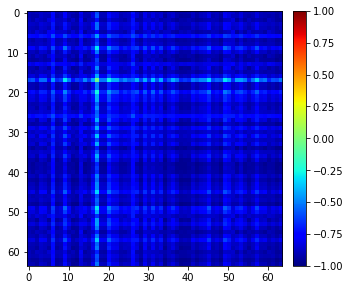

In [0]:
X_gaf=np.load('GAF/GAF_Images/X_gaf.npy')
sample_image=X_gaf[0] 
plt.figure(figsize=(5, 5))
plt.imshow(sample_image,cmap='jet')
plt.colorbar(fraction=0.0457, pad=0.04)
plt.clim(-1,1)
plt.show()


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import progressbar
from scipy import signal
from skimage.measure import block_reduce
import os
#from scipy.misc import imresize
from PIL import Image

factor=8
smoothness_factor=4
widths = np.linspace(1,64,64)
widths= 2**(widths/smoothness_factor)
dataset = X1
n=np.shape(dataset)[0]
X_sc=np.zeros((n,64,64))
signal_type = signal.ricker
pooling_function=np.mean
for i in range(0,n):
  print(i)
  cwtmatr = signal.cwt(dataset[i,:], signal_type, widths)
  X_sc[i]=block_reduce(cwtmatr, block_size=(1, factor), func=pooling_function)

print('Encoding successful!')
print('#####################################')

if not os.path.exists('SC'):
  os.makedirs('SC')

directory = 'SC/SC_Images'
dataset_name = 'X_sc.npy'
if not os.path.exists(directory):
  os.makedirs(directory)

print('Saving data...')
np.save(os.path.join(directory,dataset_name),dataset)
print(dataset_name,' saved at: ',os.path.join(directory,dataset_name))


In [0]:
dataset = X2
n=np.shape(dataset)[0]
X_sc=np.zeros((n,64,64))
signal_type = signal.ricker
pooling_function=np.mean
for i in range(0,n):
    cwtmatr = signal.cwt(dataset[i,:], signal_type, widths)
    X_sc[i]=block_reduce(cwtmatr, block_size=(1, factor), func=pooling_function)

print('Encoding successful!')
print('#####################################')
dataset_name = 'X_test_sc.npy'
if not os.path.exists(directory):
    os.makedirs(directory)

print('Saving data...')
np.save(os.path.join(directory,dataset_name),dataset)
print(dataset_name,' saved at: ',os.path.join(directory,dataset_name))


In [0]:
### Prepare Batch #######################################################

from matplotlib import pyplot as plt
import numpy as np
from numpy import newaxis


class Batch(object):
    """
    Prepare data batches for training and testing.

    For Training the batches are selected randomly.

    """

    def __init__(self):
        self.training_images = None
        self.testing_images = None

    def get_batch(self, batch_size, dataset, dataset_name):
        """
        get a batch of images

        """

        if dataset_name == 'training':

            training_set_3d = dataset

            if self.training_images is None:
                self.training_images = training_set_3d
            #               # Pad images if necessary...
            #             images = np.pad(self.training_images, pad_width=[[0, 0], [3, 4],[3, 4]],mode= "constant",constant_values=0)

            images = self.training_images[:, :, :, newaxis]


        elif dataset_name == 'testing':
            validation_set_3d = dataset

            if self.testing_images is None:
                self.testing_images = validation_set_3d
            #               # Pad images if necessary...
            #             images = np.pad(self.training_images, pad_width=[[0, 0], [3, 4],[3, 4]],mode= "constant",constant_values=0)
            images = self.testing_images[:, :, :, newaxis]


        else:

            return

        num_samples = images.shape[0]
        idx = np.random.randint(num_samples, size=batch_size)

        return images[idx]

In [0]:
### Architecture SPECIAL Building Blocks
#######################################################

# Each Layer is defined as a class and later on used as a building block for the Architecture.
import tensorflow as tf
from abc import ABCMeta, abstractmethod


class Layer(object, metaclass=ABCMeta):
    """
    Abstract Class used for general Building Blocks

    """

    def __init__(self):
        pass

    @abstractmethod
    def call(self, *args, **kwargs):
        raise NotImplementedError

    def __call__(self, *args, **kwargs):
        return self.call(*args, **kwargs)


class Unfold(Layer):
    """
    Unfold Building Block
    """

    def __init__(self,
                 scope=''):
        Layer.__init__(self)

        self.scope = scope

    def build(self, input_tensor):
        num_batch, height, width, num_channels = input_tensor.get_shape()

        return tf.reshape(input_tensor, [-1, (height * width * num_channels).value])

    def call(self, input_tensor):
        if self.scope:
            with tf.variable_scope(self.scope) as scope:
                return self.build(input_tensor)
        else:
            return self.build(input_tensor)


class Fold(Layer):
    """
    Fold Building Block
    """

    def __init__(self,
                 fold_shape,
                 scope=''):
        Layer.__init__(self)

        self.fold_shape = fold_shape
        self.scope = scope

    def build(self, input_tensor):
        return tf.reshape(input_tensor, self.fold_shape)

    def call(self, input_tensor):
        if self.scope:
            with tf.variable_scope(self.scope) as scope:
                return self.build(input_tensor)
        else:
            return self.build(input_tensor)


In [0]:
### Trainingschedule #######################################################
import tensorflow as tf

class Models(object):
    """
    Definition of the training procedure.

    """

    def __init__(self):
        pass

    #@staticmethod
    def start_new_session(self, sess):
        saver = tf.train.Saver()
        global_step = 0

        sess.run(tf.global_variables_initializer())

        return saver, global_step

    #@staticmethod
    def continue_previous_session(self, sess, ckpt_file):
        saver = tf.train.Saver()  # create a saver

        with open(ckpt_file) as file:  # read checkpoint file
            line = file.readline()  # read the first line, which contains the file name of the latest checkpoint
            ckpt = line.split('"')[1]
            global_step = int(ckpt.split('-')[1])
            print(ckpt)
        # restore
        saver.restore(sess, 'saver/'+ckpt)
        print('restored from checkpoint ' + ckpt)

        return saver, global_step

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import sys

from keras.models import Model
from keras.layers import Dense,Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, UpSampling2D

### Global Parameters
########################################################

# Change Parameters here and use them everywhere in the code using: argp.<variable_name>

parser = argparse.ArgumentParser()

# Paths/Directories
parser.add_argument("--path_data", type=str, help="Path to folder of input data")

# Work Schedule

parser.add_argument("--mode", choices=["new_training","continue_training","testing"])
parser.add_argument("--dataset", choices=["training","testing"])
parser.add_argument("--cycles",                type=int, help="Number of gradient descent steps")
parser.add_argument("--performance_eval_steps",type=int, help="Interval: number of steps to compute the loss")
parser.add_argument("--checkpoint_save_steps", type=int, help="Interval: number of steps to create a checkpoint of the model's state")
parser.add_argument("--batch_size_testing",    type=int, help="Number of images to show when testing")
parser.add_argument("--batch_size",            type=int, help="Number of images to use for computing loss while training")

# Architecture parameters

parser.add_argument("--conv_kernel_size_1",    type=int)
parser.add_argument("--conv_stride_1",         type=int)
parser.add_argument("--pool_kernel_size",      type=int)
parser.add_argument("--pool_stride",           type=int)
parser.add_argument("--nr_channels_1",         type=int, help="Number of channels in first layer")
parser.add_argument("--bottleneck_size",       type=int, help="Number of neurons in the bottleneck layer")

# Encodings
parser.add_argument("--encoding",              type=str, 
                    choices=["GAF","MTF","RP","SP","SC","GS"],
                    help="The encoding image matrix (e.g. X_gaf.npy) must be created first in Part 1!")


argp = parser.parse_args(
    ['--path_data','.',
     '--mode','new_training',
     '--dataset','training',
     '--cycles','50000',
     '--conv_kernel_size_1','4',
     '--conv_stride_1','2',
     '--pool_kernel_size','2',
     '--pool_stride','2',
     '--nr_channels_1','32', 
     '--bottleneck_size','160',
     '--batch_size','100',
     '--batch_size_testing','10',
     '--performance_eval_steps','10',
     '--checkpoint_save_steps','10000',
     '--encoding','GAF'])

### Import Encoding Matrix
########################################################

if argp.dataset=='training':
    
    if argp.encoding == 'GAF':
        X=np.load(os.path.join(argp.path_data,'GAF/GAF_Images/X_gaf.npy'))
    elif argp.encoding == 'MTF':
        X=np.load(os.path.join(argp.path_data,'MTF/MTF_Images/X_mtf.npy'))
    elif argp.encoding == 'RP':
        X=np.load(os.path.join(argp.path_data,'RP/RP_Images/X_rp.npy'))
    elif argp.encoding == 'SP':
        X=np.load(os.path.join(argp.path_data,'SP/SP_Images/X_sp.npy'))
    elif argp.encoding == 'SC':
        X=np.load(os.path.join(argp.path_data,'SC/SC_Images/X_sc.npy'))
    elif argp.encoding == 'GS':
        X=np.load(os.path.join(argp.path_data,'GS/GS_Images/X_gs.npy'))
    else:
        print('Check if encoding variable matches one of the following names:')
        print('GAF','MTF','RP','SP','SC','GS')

    n,l,_=X.shape
    print('number of images in training set:',n)
    
elif argp.dataset== 'testing': 
  
    if argp.encoding == 'GAF':
        X_test=np.load(os.path.join(argp.path_data,'GAF/GAF_Images/X_test_gaf.npy'))
    elif argp.encoding == 'MTF':
        X_test=np.load(os.path.join(argp.path_data,'MTF/MTF_Images/X_test_mtf.npy'))
    elif argp.encoding == 'RP':
        X_test=np.load(os.path.join(argp.path_data,'RP/RP_Images/X_test_rp.npy'))
    elif argp.encoding == 'SP':
        X_test=np.load(os.path.join(argp.path_data,'SP/SP_Images/X_test_sp.npy'))
    elif argp.encoding == 'SC':
        X_test=np.load(os.path.join(argp.path_data,'SC/SC_Images/X_test_sc.npy'))
    elif argp.encoding == 'GS':
        X_test=np.load(os.path.join(argp.path_data,'GS/GS_Images/X_test_gs.npy'))
    else:
        print('Check if encoding variable matches one of the following names:')
        print('GAF', 'MTF', 'RP', 'SP', 'SC', 'GS')

    n_valid,l,_=X_test.shape
    print('number of images in testing set:',n_valid)


print('Encoding:',argp.encoding)
print('image size:',l,'x',l)

class ConvolutionalAutoencoder(object):
    """
    Build the model using building Blocks
    
    """
    def __init__(self):
        """
        build the Graph
        """
        
        x = tf.placeholder(tf.float32, shape=[None, l, l, 1]) # [# batch, img_height, img_width, #channels]
        print('input',x.get_shape())
        
        h = Conv2D(filters=argp.nr_channels_1, 
                   kernel_size=argp.conv_kernel_size_1, 
                   strides=(argp.conv_stride_1, argp.conv_stride_1), 
                   padding='same',
                   activation=tf.nn.leaky_relu)(x)
        print('conv1',h.get_shape())
        
        pool1 = AveragePooling2D(pool_size=(argp.pool_kernel_size, argp.pool_kernel_size), 
                                 strides=argp.pool_stride, 
                                 padding='same')(h)
        print('pool1',pool1.get_shape())
        
        unfold = Unfold(scope='unfold')(pool1)
        print('unfold',unfold.get_shape())
        
        h = Dense(units=argp.bottleneck_size, activation=tf.nn.leaky_relu)(unfold)
        print('dense1',h.get_shape())
        
        h = Dense(units=int(unfold.get_shape()[1]), activation=tf.nn.leaky_relu)(h)
        print('dense2',h.get_shape())
        
        h = Fold(fold_shape = [-1, int(pool1.get_shape()[1]), int(pool1.get_shape()[1]), argp.nr_channels_1], 
                 scope      = 'fold')(h)
        print('fold',h.get_shape())
        
        h = UpSampling2D(size=(argp.pool_kernel_size,argp.pool_kernel_size))(h)
        print('unpool',h.get_shape())
        
        reconstruction = Conv2DTranspose(filters=1, 
                                         kernel_size=argp.conv_kernel_size_1, 
                                         strides=argp.conv_stride_1,
                                         padding='same',
                                         activation=tf.nn.leaky_relu)(h)
        
        print('reconstruction',reconstruction.get_shape())
        
        # Loss
        loss = tf.divide(tf.nn.l2_loss(x - reconstruction), argp.batch_size)  # L2 loss
        
        # Optimizer
        training = tf.train.AdamOptimizer(0.0001).minimize(loss)
        
        tf.summary.scalar('loss',loss)

        self.x = x
        self.reconstruction = reconstruction
        self.loss = loss
        self.training = training
        
    def train(self, batch_size, passes, new_training):
            """
            training process configuration

            """
            batch = Batch()

            with tf.Session() as sess:
                # prepare session
                if new_training:
                    print('new_training')

                    merged_summary = tf.summary.merge_all()
                    file_writer = tf.summary.FileWriter('tensorboard_summary', sess.graph)
                    model = Models()
                    saver, global_step = model.start_new_session(sess)
                else:

                    merged_summary = tf.summary.merge_all()
                    file_writer = tf.summary.FileWriter('tensorboard_summary', sess.graph)
                    model = Models()
                    saver, global_step = model.continue_previous_session(sess, ckpt_file='saver/checkpoint')

                # start training
                for step in range(1+global_step, 1+passes+global_step):
                    x = batch.get_batch(batch_size, dataset_name=argp.dataset, dataset=X)
                    self.training.run(feed_dict={self.x: x})

                    if step % argp.performance_eval_steps == 0:
                        print('Evaluating Performance...')
                        loss_eval = self.loss.eval(feed_dict={self.x: x})

                        result = sess.run(merged_summary,feed_dict={self.x: x})
                        file_writer.add_summary(result, step)

                        print("pass {}, training loss {}".format(step, loss_eval))

                    if step % argp.checkpoint_save_steps == 0:  # save weights
                        print('Saving Checkpoint...')
                        saver.save(sess, 'saver/cnn', global_step=step, write_meta_graph=True)
                        print('checkpoint saved')

    def reconstruct(self): 
        """
        reconstruction process configuration
        """

        batch = Batch()

        with tf.Session() as sess:
            saver, global_step = Model.continue_previous_session(sess, ckpt_file='saver/checkpoint')

            
            batch_size = argp.batch_size_testing

            if argp.dataset == 'training':
                x = batch.get_batch(batch_size, dataset_name=argp.dataset, dataset=X)
            elif argp.dataset == 'testing':
                x = batch.get_batch(batch_size, dataset_name=argp.dataset, dataset=X_test)
            else:
                sys.exit('Unexpected argument parser value for variable "dataset" ')

            org, recon = sess.run((self.x, self.reconstruction), feed_dict={self.x: x})

            org = np.squeeze(org,axis=3)
            recon = np.squeeze(recon,axis=3)
            
            
            for b in range (batch_size):
                fig_org, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
                plt.subplots_adjust(wspace=1)
                if argp.encoding!='GS':
                    image_org = axes[0].imshow(org[b],cmap='jet')
                    image_recon = axes[1].imshow(recon[b],cmap='jet')
                    image_residual = axes[2].imshow(np.abs(org[b]-recon[b]),cmap='jet')
                else:
                    image_org = axes[0].imshow(org[b],cmap='gray')
                    image_recon = axes[1].imshow(recon[b],cmap='gray')
                    image_residual = axes[2].imshow(np.abs(org[b]-recon[b]),cmap='gray')
                    
                # print(np.sum((org[b]-recon[b])**2)/2)
                plt.colorbar(image_org, fraction=0.0457, pad=0.04, ax=axes[0])
                plt.colorbar(image_recon, fraction=0.0457, pad=0.04, ax=axes[1])
                plt.colorbar(image_residual, fraction=0.0457, pad=0.04, ax=axes[2])
                
                # the colorbar limits can either be changed or left out entirely. In this case the limits get set automatically.
                if argp.encoding=='GAF':
                    image_org.set_clim(-1, 0.5)
                    image_recon.set_clim(-1, 0.5)
                    image_residual.set_clim(0,0.4)
                    axes[0].set_title('GAF: Original',fontsize=15)
                    axes[1].set_title('GAF: Reconstruction',fontsize=15)
                    axes[2].set_title('GAF: Residual',fontsize=15)
                  
                elif argp.encoding=='MTF':
                    image_org.set_clim(0, 0.4)
                    image_recon.set_clim(0,0.4)
                    image_residual.set_clim(0,0.1)
                    axes[0].set_title('MTF: Original',fontsize=15)
                    axes[1].set_title('MTF: Reconstruction',fontsize=15)
                    axes[2].set_title('MTF: Residual',fontsize=15)
                  
                elif argp.encoding=='RP':
                    image_org.set_clim(0, 2)
                    image_recon.set_clim(0, 2)
                    image_residual.set_clim(0, 1)
                    axes[0].set_title('RP: Original',fontsize=15)
                    axes[1].set_title('RP: Reconstruction',fontsize=15)
                    axes[2].set_title('RP: Residual',fontsize=15)
                  
                elif argp.encoding=='Spectro':
                    image_org.set_clim(0,-120)
                    image_recon.set_clim(0,-120)
                    image_residual.set_clim(0,40)
                    axes[0].set_title('SP: Original',fontsize=15)
                    axes[1].set_title('SP: Reconstruction',fontsize=15)
                    axes[2].set_title('SP: Residual',fontsize=15)
                  
                elif argp.encoding=='Scalo':
                    image_org.set_clim(np.min(org[b]*1.2),np.max(org[b]*1.2))
                    image_recon.set_clim(np.min(org[b]*1.2),np.max(org[b]*1.2))
#                   image_residual.set_clim(0, 0.5)
                    axes[0].set_title('SC: Original',fontsize=15)
                    axes[1].set_title('SC: Reconstruction',fontsize=15)
                    axes[2].set_title('SC: Residual',fontsize=15)
            
                elif argp.encoding=='GS':
                    image_org.set_clim(np.min(org[b]*1),np.max(org[b]*1))
                    image_recon.set_clim(np.min(org[b]*1),np.max(org[b]*1))
                    axes[0].set_title('GS: Original',fontsize=15)
                    axes[1].set_title('GS: Reconstruction',fontsize=15)
                    axes[2].set_title('GS: Residual',fontsize=15)

                plt.show()


Using TensorFlow backend.


number of images in training set: 201240
Encoding: GAF
image size: 64 x 64


In [0]:
conv_autoencoder = ConvolutionalAutoencoder()

if argp.mode == 'new_training':

    conv_autoencoder.train(batch_size   = argp.batch_size,
                           passes       = argp.cycles, 
                           new_training = True)

elif argp.mode == 'continue_training' :

    conv_autoencoder.train(batch_size   = argp.batch_size,
                           passes       = argp.cycles, 
                           new_training = False)

elif argp.mode == 'testing':

    conv_autoencoder.reconstruct()



input (?, 64, 64, 1)


conv1 (?, 32, 32, 32)

pool1 (?, 16, 16, 32)
unfold (?, 8192)
dense1 (?, 160)
dense2 (?, 8192)
fold (?, 16, 16, 32)

unpool (?, 32, 32, 32)
reconstruction (?, ?, ?, 1)
new_training
Evaluating Performance...
pass 10, training loss 1340.880859375
Evaluating Performance...
pass 20, training loss 1229.27880859375
Evaluating Performance...
pass 30, training loss 827.5814819335938
Evaluating Performance...
pass 40, training loss 284.9801025390625
Evaluating Performance...
pass 50, training loss 93.31673431396484
Evaluating Performance...
pass 60, training loss 63.59898376464844
Evaluating Performance...
pass 70, training loss 53.13603210449219
Evaluating Performance...
pass 80, training loss 37.7520866394043
Evaluating Performance...
pass 90, training loss 37.048641204833984
Evaluating Performance...
pass 100, training loss 31.25661277770996
Evaluating Performance...
pass 110, training loss 36.156837463378906
Evaluating Performance...
pass 120, training loss 37.6274223